# **Day5에 오신 것을 환영합니다**

오늘 실습에서 배워볼 것은 TTS(Text to speech)는 어떤식으로 작동하는지 이해하기 위해 TTS 모델의 입력(word2vec)과 출력(mel-spectogram)에 대해 알아보는 시간을 가져보도록 하겠습니다.



TTS의 모델 중에서 Tacotron이라는 모델을 살펴보면 Text를 입력으로 받아 Raw spectrogram을 생성합니다. 학습을 시킬 때는 <text,Audio>페어를 사용하여 End-to-End로 학습이 가능하게 됩니다.

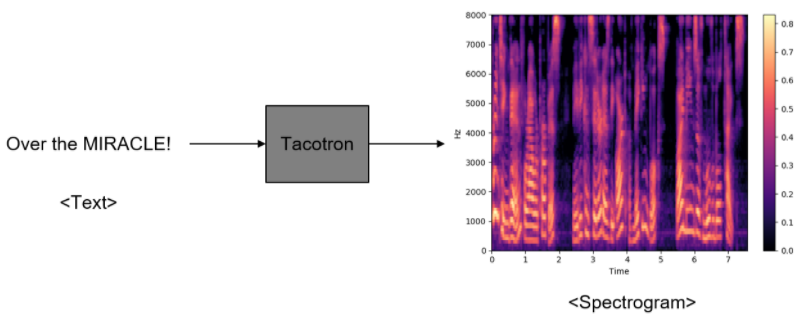

자세한 것은 하단의 링크를 확인해보시면 좋을 것 같습니다.

https://hcnoh.github.io/2018-12-11-tacotron


이번 실습에서는 TTS의 기본이 되는 입출력 데이터를 어떻게 다루는지에 대한 기본 내용을 다루도록 하겠습니다. 

특히, 문장을 이용한 word2vec은 어떻게 작동을 하는지, 음성데이터에서 spectrogram은 어떻게 만들어지는지에 대해 공부해보도록 하겠습니다.

먼저, Word2vec의 모델중 하나인 Skip gram을 살펴보도록 하겠습니다.

Skip gram의 경우 중심단어가 주어졌을 때 그 주변 단어로 함께 쓰이는 단어들을 예측하게 학습시킨 모델을 통해서 단어의 identity, 즉, embedding 표현을 학습하는 방법입니다.

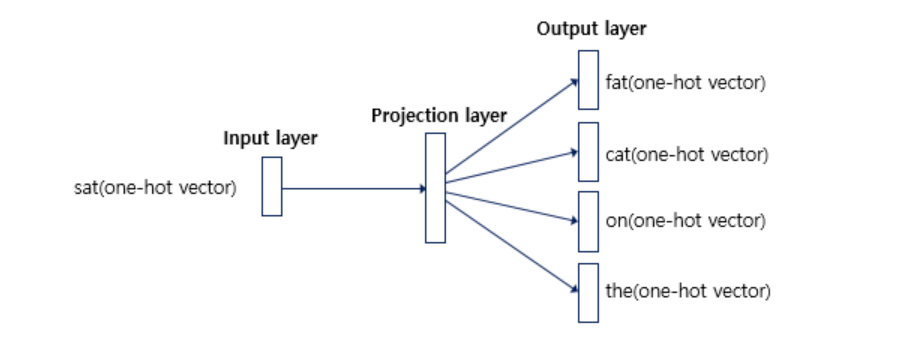

위의 예시처럼 sat이라는 단어가 입력으로 들어가면 그 앞뒤에 자주 등장하는 단어를 출력으로 하는 모델입니다.
그러나 더 궁극적인 목적은 예를 들어 sat과 비슷한 의미의 단어인 subside가 input으로 들어왔을 때 출력으로 sat의 출력과 비슷한 단어들이 output으로 나오도록 projection layer를 잘 학습시키는데에 있습니다. 이렇게 학습을 시킨다면 projection layer에서 sat과 subside는 비슷한 vector값을 가질 것입니다.


PyTorch로 직접 구현하기 이전에 많은 문장들로 미리 학습이 된 모델로 결과를 살펴보도록 하겠습니다.

genism 패키지로 구현되어 모든 소스코드를 제공하는 부분은 Pytorch로 시작하는 딥러닝 입문(https://wikidocs.net/60855 ; under CC licensed)을 참조하였습니다.


참고) 실습을 시작하기에 앞서 word2vec에 대해 더 자세하게 이해하고 싶다면 다음 링크를 읽어보세요!

1) https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/03/30/word2vec/

2) https://dreamgonfly.github.io/blog/word2vec-explained/

In [ ]:
import nltk
nltk.download('punkt')
import urllib.request
import zipfile
from lxml import etree
import re
from nltk.tokenize import word_tokenize, sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/GaoleMeng/RNN-and-FFNN-textClassification/master/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x7f89f45849d0>)

위의 xml파일을 출력해보면 다음과 같이 구성이 되어있습니다.

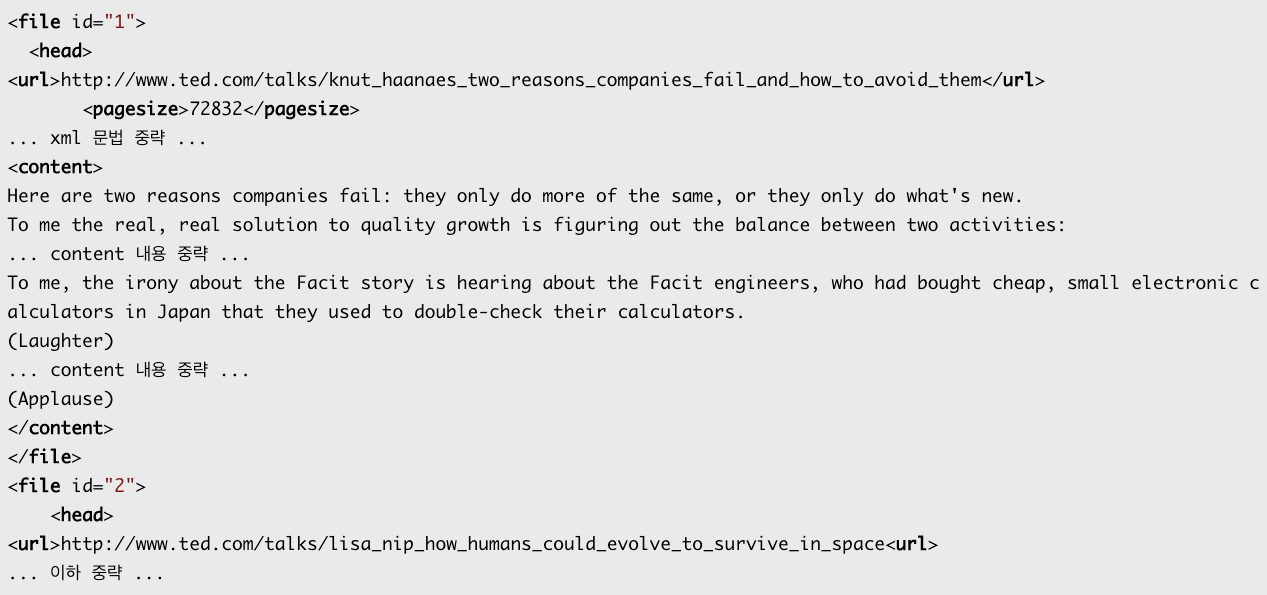

In [ ]:
# xml 파일로부터 <content>와 </content> 사이의 내용만 가져옵니다
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')

target_text = etree.parse(targetXML)
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분처럼 괄호 안에 들어 있는 것들을 모두 제거합니다
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행합니다
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환합니다
normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화합니다
result = []
result = [word_tokenize(sentence) for sentence in normalized_text]

In [ ]:
print('총 샘플의 개수 : {}'.format(len(result)))

총 샘플의 개수 : 273424


In [ ]:
from gensim.models import Word2Vec, KeyedVectors  
model = Word2Vec(sentences=result, size=100, window=5, min_count=5, workers=4, sg=1)

In [ ]:
#입력한 단어와 가까이에 있는 (상관관계가 높은) 단어들을 출력으로 보여줍니다.
#doctor 대신 임의의 단어를 입력으로 바꿔가면서 출력을 확인해보세요.
model_result = model.wv.most_similar("doctor")
print(model_result)

[('physician', 0.7756150364875793), ('therapist', 0.7706958055496216), ('nurse', 0.7459981441497803), ('surgeon', 0.7372311949729919), ('psychiatrist', 0.7040786743164062), ('patient', 0.7020873427391052), ('specialist', 0.6992111206054688), ('boss', 0.6933399438858032), ('technician', 0.6879547834396362), ('dancer', 0.6844509840011597)]


이제는 Pytorch로 간단한 word2vec model 구현해봅시다!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

이번에는 긴 문서가 아닌 짤막한 문장들로 구성된 corpus로 직접 학습을 시켜보려고 합니다.


학습을 시키기 위해서는 문장의 형태가 아닌 토큰화시킨 단어들을 입력으로 넣어주어야 합니다. 밑의 corpus를 토큰화 시키는 작업부터 해봅시다.

In [ ]:
corpus = [
    'he is a king',
    'she is a queen',
    'he is a man',
    'she is a woman',
    'warsaw is poland capital',
    'berlin is germany capital',
    'paris is france capital', 
    'seoul is korea capital',  
    'bejing is china capital', 
    'tokyo is japan capital',   
    'She is kind',
    'He is French',
    'She is quiet',
    'She is a twin',
    'He is a writer',
    'He is a painter',
    'The boy is kind'
]

In [ ]:
#문제
def tokenize_corpus(corpus):
    # [Do it yourself] split 함수를 사용하여 위의 문장들을 다음과 같이 토큰화 된 형태의 결과가 출력되도록 만들어보세요.
    # [['he', 'is', 'a', 'king'], ['she', 'is', 'a', 'queen'], ['he', 'is', 'a', 'man'], ...]]
    tokens = 
    return tokens

tokenized_corpus = tokenize_corpus(corpus)
print(tokenized_corpus)

Hint: split 함수와 관련된 것은 다음의 문서를 참조하세요


https://wikidocs.net/13

corpus를 문장별 단어 분할을 완료하였다면 그 안의 단어들이 겹치지 않도록 embedding을 생성할 vocab 집합을 구성하는 소스코드를 작성해봅시다!

In [ ]:
#문제
vocab = []

# [Do it yourself] 문장을 1개씩 보면서 그 안의 단어들 중 vocab안의 단어와 겹친다면 넣지 않는 소스코드를 작성해주세요!
# 예시 [['he', 'is', 'a', 'king'], ['she', 'is', 'a', 'king']] => vocab = ['he','is','a','king','she'] 
for sentence in tokenized_corpus:



#vocab에 담은 단어들을 인덱싱 하여 순서를 정해줌
word2idx = {w: idx for (idx, w) in enumerate(vocab)}
idx2word = {idx: w for (idx, w) in enumerate(vocab)}
vocab_size = len(vocab)

In [ ]:
#문제
# window_size는 현재 단어에서 양옆의 몇개의 단어를 참조할 것인지 결정
window_size = 2
idx_pairs = []

for sentence in tokenized_corpus:
    # 단어들로 이루어진 문장토큰을 vocab을 토대로 indexing 한 문장토큰으로 바꿔줍니다.
    # 예시 : ['he', 'is', 'a', 'king'] => word2idx : {'he': 0, 'is': 1, 'a': 2, 'king': 3 ...} => [0, 1, 2, 3]
    indices = [word2idx[word] for word in sentence]

    # [Do it yourself] 각각의 indexing된 문장토큰을 돌면서 center word를 중심으로 왼쪽의 2개 단어와 오른쪽 2개의 단어까지를 각각 쌍으로 pairs에 저장하는 소스코드를 짜봅시다!
    # center word는 모든 단어를 1번씩 거치며 center를 중심으로 왼쪽이나 오른쪽에 2개 미만의 단어가 있는 경우 범위 안에 있는 단어만 짝으로 인정하세요.
    # 예시 : [[0, 1, 2, 3] [4, 1, 2, 5]]라는 2개의 문장이 있을 때 pair는 총 20개가 됩니다.
    # pairs = [(0, 1), (0, 2), (1, 0), (1, 2), (1, 3), (2, 0), (2, 1), (2, 3), (3, 1), (3, 2),
    #         (4, 1), (4, 2), (1, 4), (1, 2), (1, 5), (2, 4), (2, 1), (2, 5), (5, 1), (5, 2)]
    for center_word_pos in range(len(indices)):
        for w in range(-window_size, window_size + 1):
            # 여기를 채워주세요!

idx_pairs = np.array(idx_pairs)

numpy에서 onehot벡터로 만들어주기 위한 함수 eye 


https://numpy.org/devdocs/reference/generated/numpy.eye.html

In [ ]:
X = []
y = []
# model에 입력으로 넣어주기 위한 data는 x에 one-hot vector의 형태로 넣어주며 loss function은 
# cross entropy 함수를 쓰므로 target(label)은 y에 실수의 형태로 넣어줍니다.
for data, target in idx_pairs:
    X.append(np.eye(vocab_size, k=0)[data])
    y.append(target)

X = torch.FloatTensor(np.array(X))
y = torch.Tensor(np.array(y)).long() 

print(X)
print(y)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([ 1,  2,  0,  2,  3,  0,  1,  3,  1,  2,  1,  2,  4,  2,  5,  4,  1,  5,
         1,  2,  1,  2,  0,  2,  6,  0,  1,  6,  1,  2,  1,  2,  4,  2,  7,  4,
         1,  7,  1,  2,  1,  9,  8,  9, 10,  8,  1, 10,  1,  9,  1, 12, 11, 12,
        10, 11,  1, 10,  1, 12,  1, 14, 13, 14, 10, 13,  1, 10,  1, 14,  1, 16,
        15, 16, 10, 15,  1, 10,  1, 16,  1, 18, 17, 18, 10, 17,  1, 10,  1, 18,
         1, 20, 19, 20, 10, 19,  1, 10,  1, 20,  1, 22, 21, 22, 21,  1,  1, 24,
        23, 24, 23,  1,  1, 25, 21, 25, 21,  1,  1,  2, 21,  2, 26, 21,  1, 26,
         1,  2,  1,  2, 23,  2, 27, 23,  1, 27,  1,  2,  1,  2, 23,  2, 28, 23,
         1, 28,  1,  2, 30,  1, 29,  1, 22, 29, 30, 22, 30,  1])


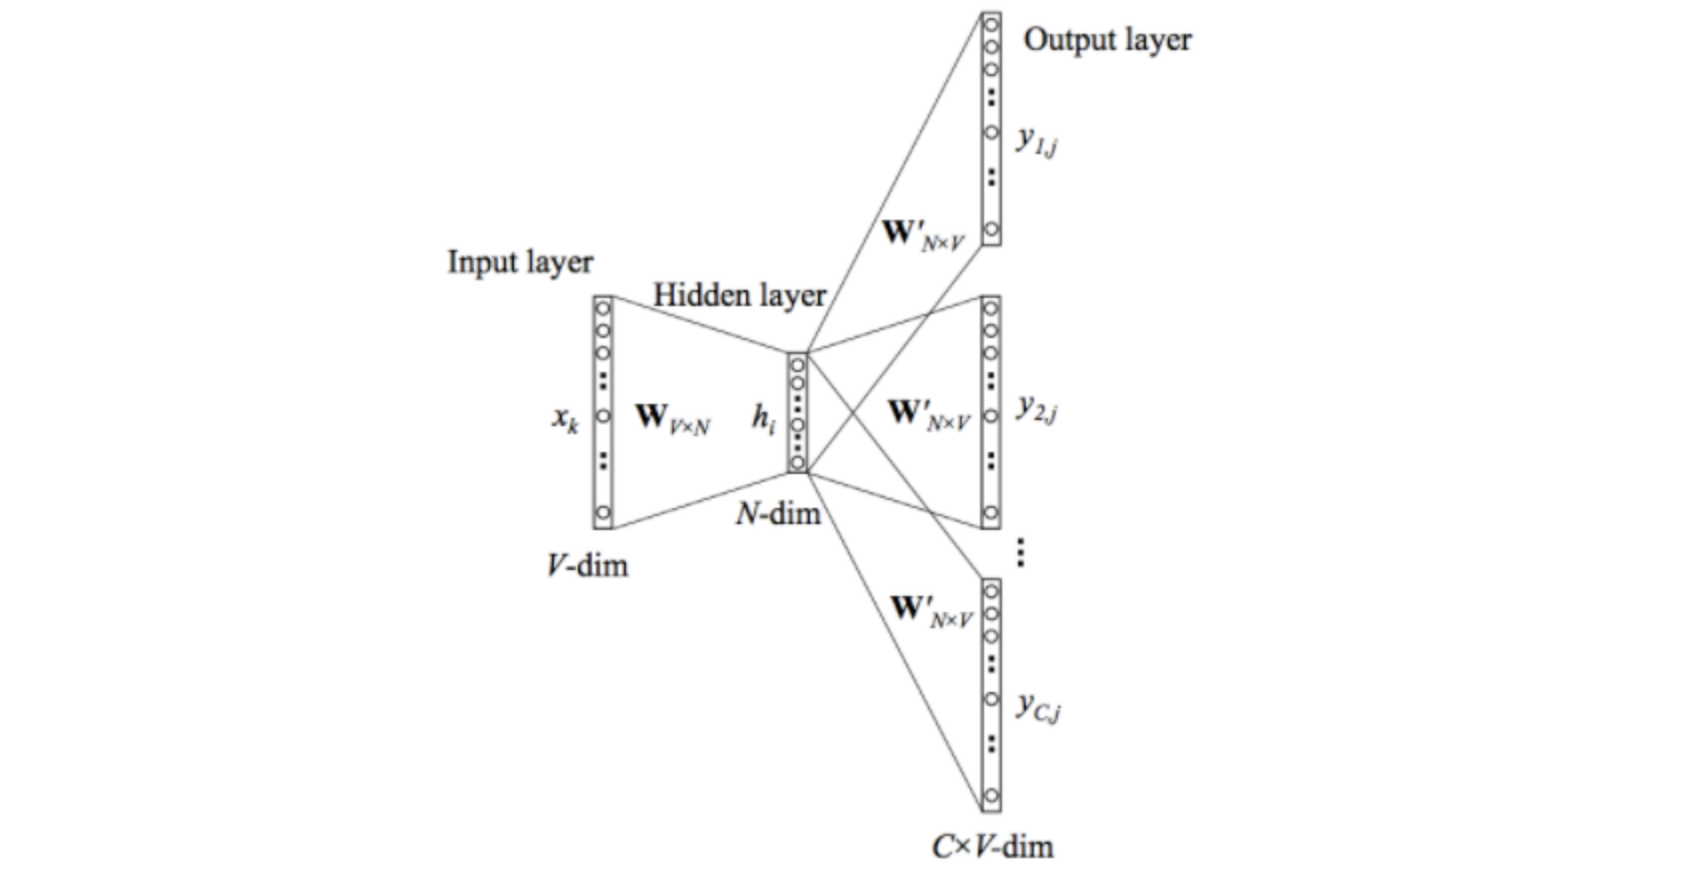

그림 출처 : https://reniew.github.io/22/

아주 간단한 형태의 모델입니다. 입력과 출력은 모두 V dimension으로 같으며 bottleneck이 되는 hidden layer는 N dimension으로 이루어진 fully connected layer 2개로 이루어진 모델입니다. 또한 hidden layer에서는 여타의 다른 딥러닝 모델들과는 다르게 activation function이 존재하지 않아 일반적인 딥러닝 모델의 hidden layer와 구분하기 위해 projection layer라고 부르기도 합니다.

In [ ]:
#문제
class Word2VecModel(nn.Module):
    def __init__(self,inout_dim):
        super().__init__()
        # [Do it yourself] fully-connected layer 2개가 쌓인 구조입니다. 입출력의 크기는 onehot vector x의 길이와 같습니다.
        # bottle neck은 2차원이 되도록 구성해주세요!
        # nn.Linear 함수를 쓰시면 됩니다.
        self.linear1 = 
        self.linear2 = 

    def forward(self,x):
        # [Do it yourself] 위에서 만든 layer들을 쌓아주세요. model의 input은 x입니다.


model = Word2VecModel(X.shape[-1])

In [ ]:
# optimizer 설정
optimizer = optim.Adam(model.parameters())
nb_epochs = 3000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    prediction = model(X)

    # cost 계산
    cost = F.cross_entropy(prediction, y)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    # 20번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/3000 Cost: 3.464456
Epoch  100/3000 Cost: 3.300817
Epoch  200/3000 Cost: 3.077877
Epoch  300/3000 Cost: 2.850893
Epoch  400/3000 Cost: 2.709150
Epoch  500/3000 Cost: 2.627887
Epoch  600/3000 Cost: 2.568612
Epoch  700/3000 Cost: 2.522362
Epoch  800/3000 Cost: 2.486143
Epoch  900/3000 Cost: 2.457012
Epoch 1000/3000 Cost: 2.432505
Epoch 1100/3000 Cost: 2.411084
Epoch 1200/3000 Cost: 2.391940
Epoch 1300/3000 Cost: 2.374668
Epoch 1400/3000 Cost: 2.359032
Epoch 1500/3000 Cost: 2.344852
Epoch 1600/3000 Cost: 2.331974
Epoch 1700/3000 Cost: 2.320278
Epoch 1800/3000 Cost: 2.309662
Epoch 1900/3000 Cost: 2.300023
Epoch 2000/3000 Cost: 2.291241
Epoch 2100/3000 Cost: 2.283201
Epoch 2200/3000 Cost: 2.275796
Epoch 2300/3000 Cost: 2.268949
Epoch 2400/3000 Cost: 2.262600
Epoch 2500/3000 Cost: 2.256713
Epoch 2600/3000 Cost: 2.251257
Epoch 2700/3000 Cost: 2.246208
Epoch 2800/3000 Cost: 2.241539
Epoch 2900/3000 Cost: 2.237220
Epoch 3000/3000 Cost: 2.233220


In [ ]:
vector = model.state_dict()['linear1.weight'].T + model.state_dict()['linear1.bias'].view(1,-1)
w2v_df = pd.DataFrame(vector.numpy(), columns = ['x1', 'x2'])
w2v_df['word'] = vocab
w2v_df = w2v_df[['word','x1','x2']]
w2v_df

,word,x1,x2
0,he,-1.667637,-2.880095
1,is,-0.035219,-0.325619
2,a,-0.696484,0.229611
3,king,-1.773437,-3.219985
4,she,-1.668999,-2.882016
5,queen,-1.759712,-3.168633
6,man,-1.733560,-3.103789
7,woman,-1.685416,-2.944966
8,warsaw,-2.583331,0.539151
9,poland,-0.034277,-1.896051


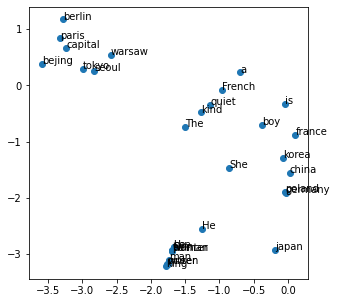

In [ ]:
ano = w2v_df['word'].values
x1 = w2v_df['x1'].values
x2 = w2v_df['x2'].values 

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x1, x2)

for i, txt in enumerate(ano):
    ax.annotate(txt, (x1[i], x2[i]))



---



mel-spectrogram과 관련된 모든 코드는 제공됩니다.


음성같은 신호를 처리하는 방법을 배우지 않은 분들도 많을 것이라 생각되어 이런 과정을 거쳐서 mel-spectrogram이 만들어지는구나를 각 셀을 실행시키면서 이해하는 식으로 실습하시기 바랍니다.

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')   

Mounted at /content/drive


In [ ]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt  

FIG_SIZE = (15,10)

음성파일은 링크에서 다운받아 본인의 Gdrive에 저장한 후 path를 다음과 같이 입력해주세요


https://drive.google.com/file/d/1WfIiM0reb6rCGqEi22yt2gTDHFqqTt1T/view?usp=sharing

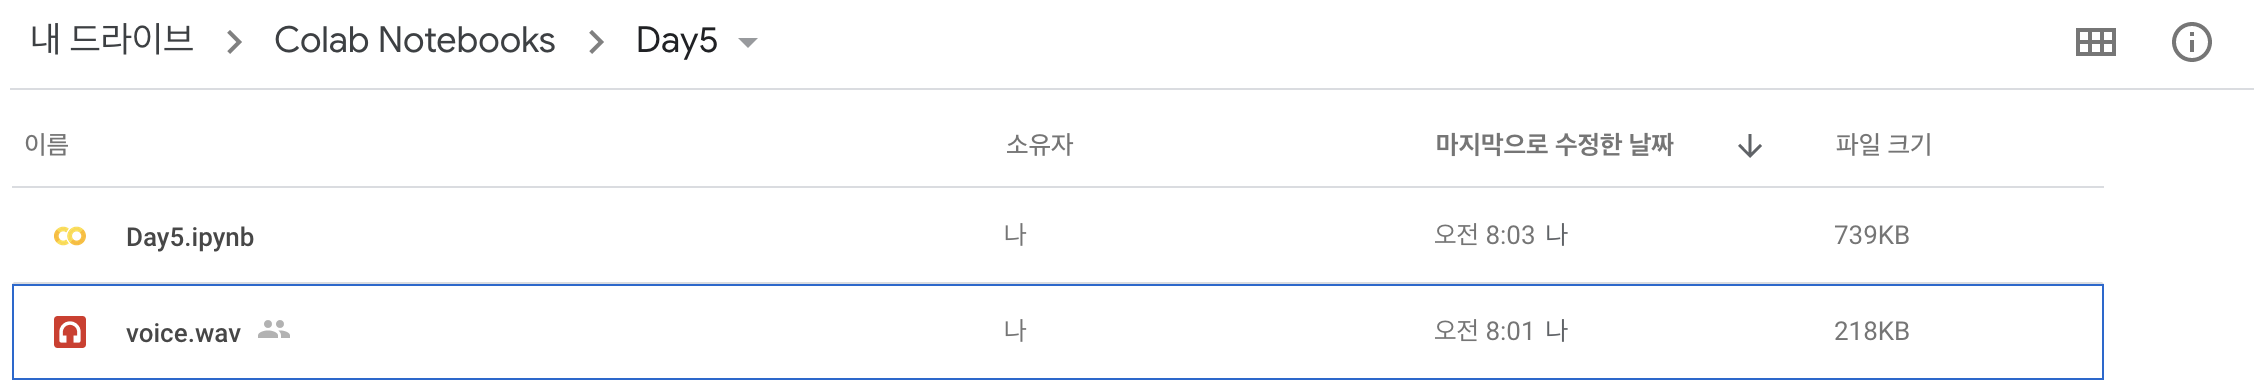

In [ ]:
# 음성 파일 load
file = "/content/drive/My Drive/Colab Notebooks/Day5/voice.wav"
sig, sr = librosa.load(file)

Text(0.5, 1.0, 'Waveform')

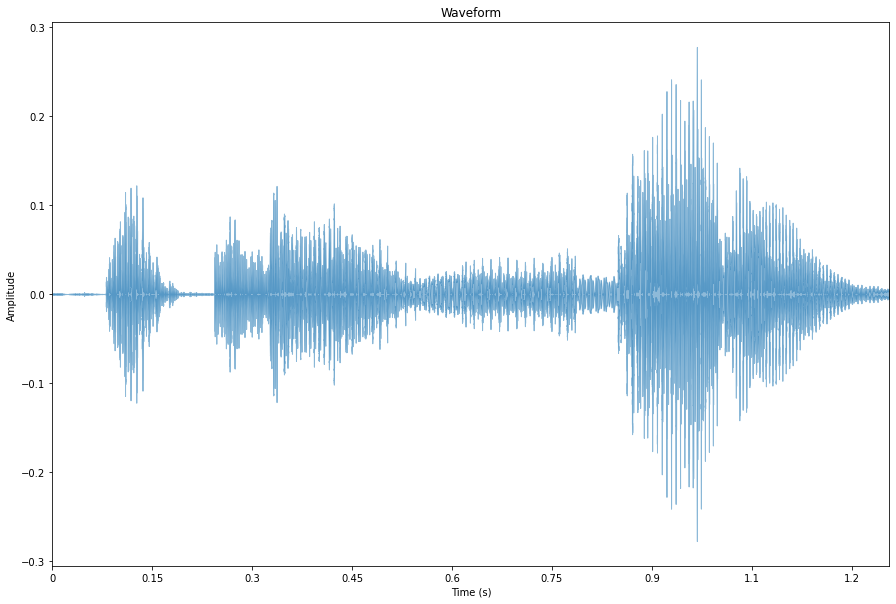

In [ ]:
# 음성 파일 load 확인
plt.figure(figsize=FIG_SIZE)
librosa.display.waveplot(sig, sr, alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

In [ ]:
!IPython.display.Audio(data=y, rate=sr)

/bin/bash: -c: line 0: syntax error near unexpected token `data=y,'
/bin/bash: -c: line 0: `IPython.display.Audio(data=y, rate=sr)'


참고) Fourier 변환이 무엇인지 궁금하다면 다음을 참조하세요!


블로그 : https://darkpgmr.tistory.com/171


영상 : www.youtube.com/watch?v=spUNpyF58BY&feature=youtu.be

Text(0.5, 1.0, 'Power spectrum')

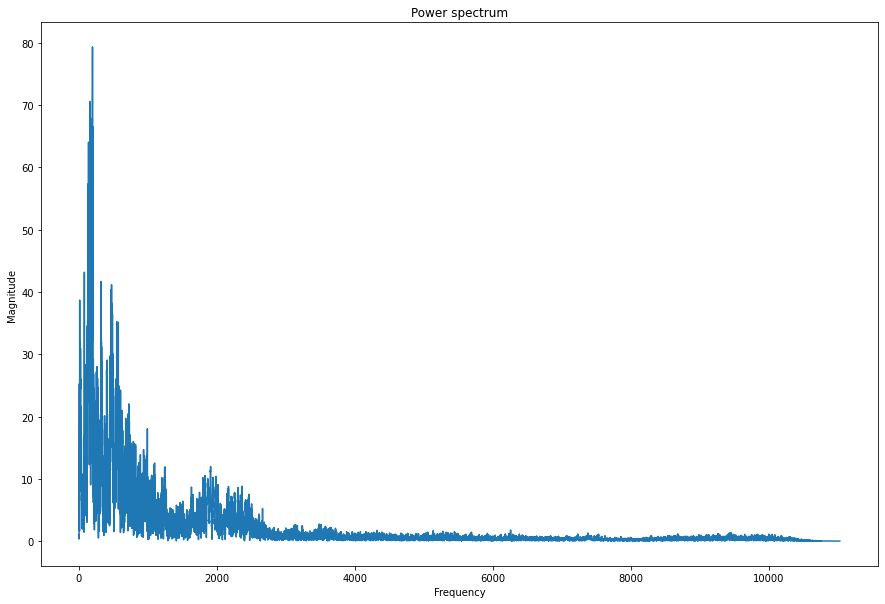

In [ ]:
# 단순 퓨리에 변환으로 스펙트럼 구하기
fft = np.fft.fft(sig)

# 복소공간 값 절댓갑 취해서, magnitude 구하기
magnitude = np.abs(fft)

# Frequency 값 만들기
f = np.linspace(0,sr,len(magnitude))

# 푸리에 변환을 통과한 specturm은 대칭구조로 나와서 high frequency 부분 절반을 날려고 앞쪽 절반만 사용한다.
left_spectrum = magnitude[:int(len(magnitude)/2)]
left_f = f[:int(len(magnitude)/2)]

plt.figure(figsize=FIG_SIZE)
plt.plot(left_f, left_spectrum)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")

참고) STFT(short time fourier transform)과 spectogram에 대해 궁금하다면 다음의 블로그를 읽어보세요!

https://sanghyu.tistory.com/37

Text(0.5, 1.0, 'Spectrogram (dB)')

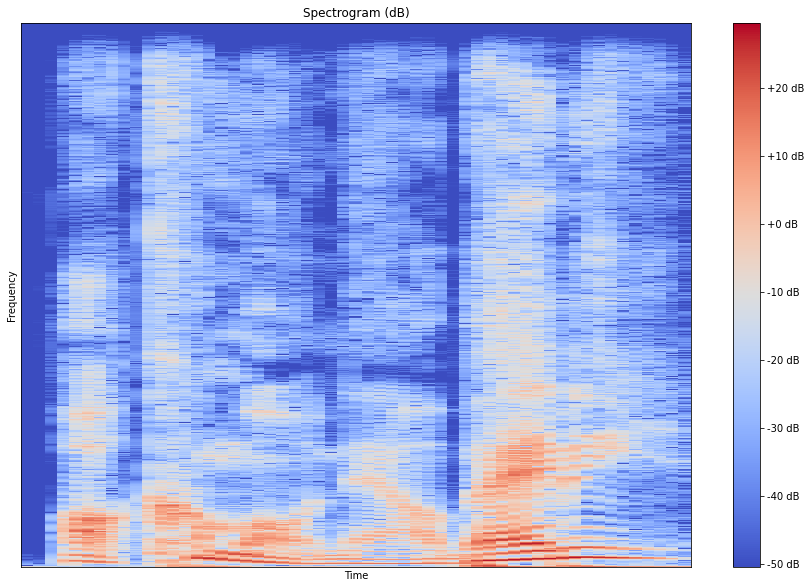

In [ ]:
# STFT를 사용하여 spectrogram 생성하기
hop_length = 512  # 건너뛰는 간격
n_fft = 2048  # 윈도우 사이즈

# calculate duration hop length and window in seconds
hop_length_duration = float(hop_length)/sr
n_fft_duration = float(n_fft)/sr

# STFT
stft = librosa.stft(sig, n_fft=n_fft, hop_length=hop_length)

# 복소공간 값 절댓값 취하기
magnitude = np.abs(stft)

# magnitude > Decibels 
log_spectrogram = librosa.amplitude_to_db(magnitude)

# display spectrogram
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")

사람들은 음성 신호를 인식할 때 주파수를 linear scale로 일정하게 인식하지 못합니다. 즉, 가청주파수는 최대 18,000Hz까지지만 목소리와 악기는 대부분 4,000Hz 이내에 존재하여 2,000Hz에서 2,500Hz의 변화는 잘 인식하지만 16,000Hz에서 16,500Hz의 변화는 잘 인식하지 못합니다. 이 때문에 우리는 log-scale의 그래프로 변환하고자 하여 mel-scale을 도입하게 됩니다.

Spectrogram에서 mel spectrogram으로 변환하는 방법은 다음과 같습니다.

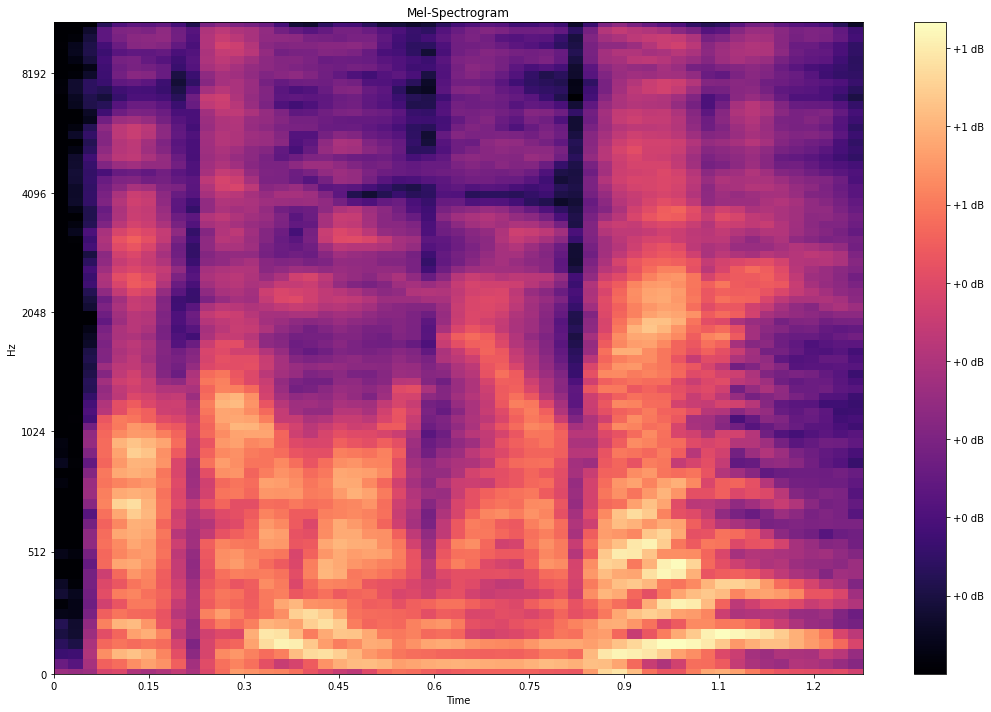

In [ ]:
# Mel spectrogram 생성하기
# Mel filter 개수 설정하기
n_mels = 80

# mel filter 정의 및 mel spectrogram 구하기
mel_basis = librosa.filters.mel(sr, n_fft, n_mels)  # (n_mels, 1+n_fft//2)
mel = np.dot(mel_basis, magnitude)  # (n_mels, t)

# to decibel
mel = 20 * np.log10(np.maximum(1e-5, mel))

# normalize
mel = np.clip((mel - 20 + 100) / 100, 1e-8, 1)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(mel, y_axis='mel', sr=sr, hop_length=hop_length, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.show()

참고) Mel-Frequency cepstral coefficient(MFCC)에 대한 것은 다음의 자료를 참고하세요!

https://brightwon.tistory.com/11

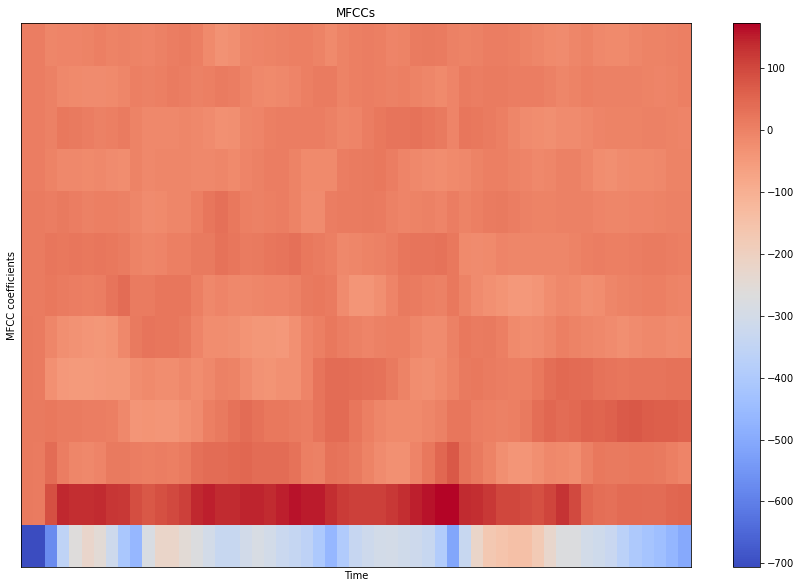

In [ ]:
# MFCCs

# extract 13 MFCCs
MFCCs = librosa.feature.mfcc(sig, sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

# show plots
plt.show()

In [ ]:
수고하셨습니다.